# D(St)reams of Anomalies

In this project, I took NYC taxi data and found anomalies in the data. I was interested in this data set as the description stated that one of the anomalies was the NYC marathon. I would love to run the NYC marathon one day, so I choose this data. 

In [1]:
import pandas as pd
import numpy as np 

I started by importing the data and looking seeing how the data was formatted. 

In [2]:
data = pd.read_csv('~/Documents/EECS/EECS_731/HW/EECS731_6/data/nyc_taxi.csv')

In [3]:
data.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


I started analyzing the data by looking at the meaning of the value column. From kaggle, "data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets" So, the number in the value column is the combided number of riders in that 30 minute chunk.  

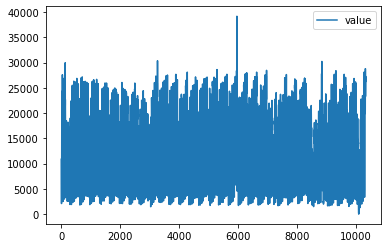

In [4]:
data.plot()

Right away, I see there is one major anomaly. At 6000, but that didn't tell me the day or give the reasoning behind the anomaly. Furthermore, this graph isn't a great way to visualize the anomalies. 

Below, I wanted to see what the min, max and average values were to understand what an anomaly would be. 

In [5]:
data.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


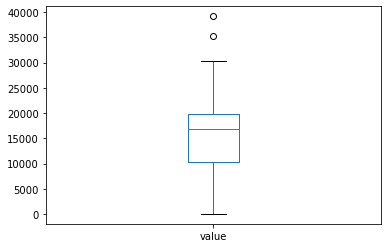

In [6]:
data['value'].plot(kind='box')
#plt.show()

In [7]:
import datetime
data['timestamp'] =  pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [8]:
#data['year'] = data['timestamp'].dt.year
#data['month'] = data['timestamp'].dt.month
#data['day'] = data['timestamp'].dt.day
#data['hour'] = data['timestamp'].dt.hour
#data['minute'] = data['timestamp'].dt.minute

I converted the time column to datatime format. At first, I thought I needed to break the columns apart by year, month, day, hour, minute, but that didn't work out as I planned. I ended up just needing the timestamp value. 

In [9]:
data.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


I see that I need to group the properties of values by time to better see the anomalies. 

In [10]:
data = data.set_index('timestamp')

In [11]:
data.dropna()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [12]:
print(data.index)

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)


# Feature Engineering 

With help from: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
I took the intial data and look at averages. Specifically, I looked at the weekly, daily, and monthly averages. 

In [13]:
%matplotlib inline
import seaborn; seaborn.set()

In [14]:
weekly = data.resample('W').sum()

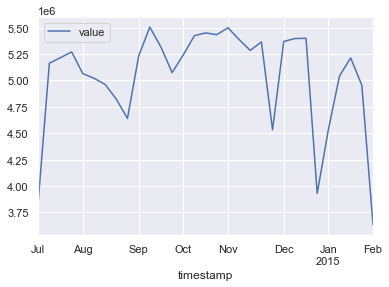

In [15]:
weekly.plot()

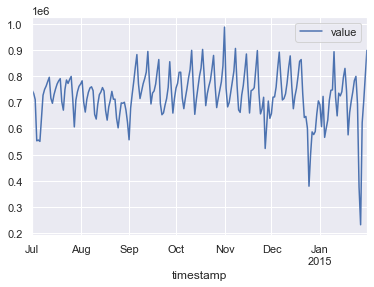

In [16]:
daily = data.resample('D').sum()
daily.plot()

Ah, this gave me a much better look at when the anomalies occur. At a rough glance, it looks like the normal amount of riders occurs aroudn 0.75 e 6. I say that there is a general steady amount with anomalies that occur at the end of November, the end of December,  and the end of January. The beginning of November is also higher than normal. That makes sense because of Halloween, Thanksgiving, and Christmas. There looks like there might be something at the end of Septemeber and end of January but I'm not sure what those could be. 

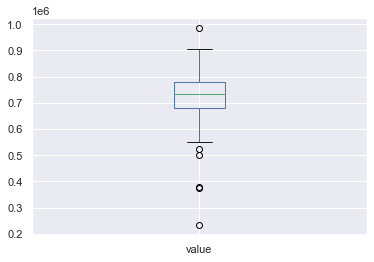

In [17]:
daily['value'].plot(kind='box')

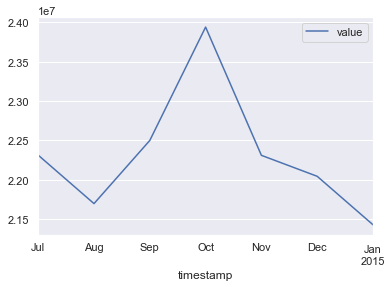

In [18]:
monthly = data.resample('M').sum()
monthly.plot()

I can't see anything with monthly or hourly data. 

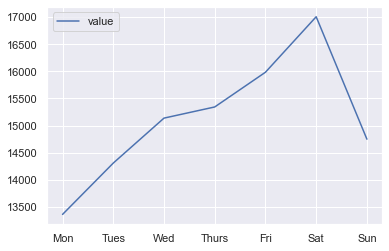

In [19]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot();

This doesn't mean anything, but it's cool to do. Most taxi riders on Saturday, as expected. The people have to get to brunch somehow! 

At least now the daily graph makes sense. The spikes up and down are from the different days of the week, Monday-Sunday. 

# Interquartile Range (IQR)

After looking at the average daily data, I decided to use the interquartile range for anomaly detection. That is, I wanted to only keep values in 25% - 75% quartile range. 

I used help from this stack overflow post to implement. https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr

In [20]:
q1 = data['value'].quantile(.25)
q3 = data['value'].quantile(.75)
#mask = data['value'].between(q1, q2, inclusive=True)
#iqr = data.loc[mask, 'value']

In [21]:
mask = data['value'].between(q1, q3, inclusive=True)
iqr = data.loc[mask, 'value']

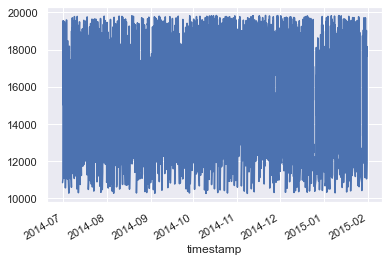

In [22]:
iqr.plot()

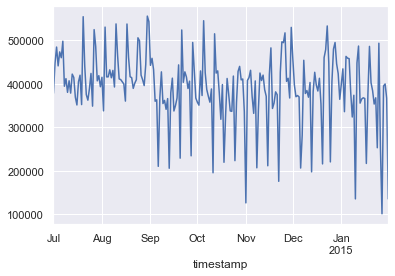

In [23]:
daily_iqr = iqr.resample('D').sum()
daily_iqr.plot()

In [24]:
iqr.describe()

count     5160.000000
mean     16313.064147
std       2359.987115
min      10263.000000
25%      14844.500000
50%      16778.000000
75%      18151.000000
max      19838.000000
Name: value, dtype: float64

The minimum value is 10,263 and the maximum value is 19838. Before, the minimum value was 8 and the maximum value was 39,197. So, we did remove some anomalies. 

Futhermore, the daily graph trends more evenly. There isn't a big spike at Halloween or Thanksgiving. 

It also looks like there are more taxi riders in July, August, and September. I guess this makes sense because people are more active in the summer.  

# Isolation Forest

The next anomaly detection model I choose was Isolation forest. This model works by creating a path to each value. The shorter the path lenght, the more likely to be an anomly. 

I used the followign to websites for implementation 
- https://blog.paperspace.com/anomaly-detection-isolation-forest/
- https://www.vshsolutions.com/blogs/using-isolation-forest-for-outlier-detection-in-python%EF%BB%BF/

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
daily.describe()

,value
count,215.000000
mean,726603.330233
std,92994.768952
min,232058.000000
25%,681849.500000
50%,734397.000000
75%,778052.500000
max,986568.000000


I decided to use daily data because I was interested in seeing the days that the anomalies occured. The min value is 232,058 and the max value is 986,568. So, I can make sure the forest is correct by detecting these anomalies. 

I didn't do a train, test split, becuase I am only trying to find the anomalies, not predict new anomalies. So, I just used all the given data to determine outliers based on the previous data. 

In [27]:
# Isolation Forest ----
X = daily
model=IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(X)

IsolationForest(contamination=0.1, n_estimators=500)

In [28]:
data['anomaly']=model.predict(data[['value']])
data.head(5)

,value,anomaly
timestamp,,
2014-07-01 00:00:00,10844,-1
2014-07-01 00:30:00,8127,-1
2014-07-01 01:00:00,6210,-1
2014-07-01 01:30:00,4656,-1
2014-07-01 02:00:00,3820,-1


In [29]:
anomaly=data.loc[data['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                     value  anomaly
timestamp                          
2014-07-01 00:00:00  10844       -1
2014-07-01 00:30:00   8127       -1
2014-07-01 01:00:00   6210       -1
2014-07-01 01:30:00   4656       -1
2014-07-01 02:00:00   3820       -1
...                    ...      ...
2015-01-31 21:30:00  24670       -1
2015-01-31 22:00:00  25721       -1
2015-01-31 22:30:00  27309       -1
2015-01-31 23:00:00  26591       -1
2015-01-31 23:30:00  26288       -1

[10320 rows x 2 columns]


It says that every values is an anomaly... Hmm... Not true. 

In [30]:
outliers_counter = len(data[data['value'] > 27000])
outliers_counter

89

In [31]:
print("Accuracy percentage:", 100*list(data['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 11595.505617977527


The accuracy is terrible. So, I retried with fewer estimator. 

In [32]:
iso_forest = IsolationForest(n_estimators=300, contamination=0.10)
iso_forest = iso_forest.fit(X)

In [33]:
isof_outliers = iso_forest.predict(X)

In [34]:
isoF_outliers_values = X[iso_forest.predict(X) == -1]
print(isoF_outliers_values)

             value
timestamp         
2014-07-04  552565
2014-07-06  550285
2014-09-01  556314
2014-09-06  881714
2014-09-20  862756
2014-09-27  854486
2014-10-18  901390
2014-10-25  878462
2014-10-31  838721
2014-11-01  986568
2014-11-08  905152
2014-11-15  883958
2014-11-27  523184
2014-12-06  890958
2014-12-13  876676
2014-12-19  855719
2014-12-20  862639
2014-12-25  379302
2014-12-26  499102
2015-01-04  565709
2015-01-26  375311
2015-01-27  232058


This includes the min value is 232,058 and the max value is 986,568. So, I think it is a pretty good detector and gives a better description of the outliers than before. 

In [35]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05)
iso_forest = iso_forest.fit(X)
isof_outliers = iso_forest.predict(X)
isoF_outliers_values = X[iso_forest.predict(X) == -1]
print(isoF_outliers_values)

             value
timestamp         
2014-07-06  550285
2014-09-20  862756
2014-10-18  901390
2014-11-01  986568
2014-11-08  905152
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-04  565709
2015-01-26  375311
2015-01-27  232058


Above are the dates I found to be anomalies. As I saw in the inital feature engineering, these dates include the day after Halloween, days around Thanksgiving, and Christmas. The marathon this year, 2014, took place on Nov 2nd. Neither model seems to catch this as a anomaly. So, my inital thinking about the marathon was incorrect. 